In [67]:
import os
import gzip
import json
import pandas as pd
from tqdm import tqdm  # Import tqdm
import numpy as np

from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import pandas as pd
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer

import netwulf as nw
import networkx as nx

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Friis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Download link: https://amazon-reviews-2023.github.io/
input_path = "Movies_and_TV.jsonl.gz"
# Give the output CSV a name:
output_path = "Movies_and_TV_Full.csv" #5.8GB file

# Check if the output file already exists
if os.path.exists(output_path):
    print(f"The file '{output_path}' already exists.")
else:
    # Depends on available RAM, if set too high can cause crashing.
    chunk_size = 150000
    buffer = []
    is_first_chunk = True

    with gzip.open(input_path, 'rt', encoding='utf-8') as f:
        total_lines = sum(1 for line in f)  # Count total lines for progress bar

    with gzip.open(input_path, 'rt', encoding='utf-8') as f:
        for i, line in tqdm(enumerate(f, 1), total=total_lines, desc="Loading reviews", unit="line"):
            buffer.append(json.loads(line))

            if i % chunk_size == 0:
                df_chunk = pd.DataFrame(buffer)
                df_chunk.to_csv(output_path, mode='w' if is_first_chunk else 'a',
                                header=is_first_chunk, index=False)
                buffer = []
                is_first_chunk = False

    # Final chunk
    if buffer:
        df_chunk = pd.DataFrame(buffer)
        df_chunk.to_csv(output_path, mode='w' if is_first_chunk else 'a',
                        header=is_first_chunk, index=False)
        print("Conversion to CSV Finished")

The file 'Movies_and_TV_Full.csv' already exists. Skipping the load process.


In [20]:
# Load the CSV
df = pd.read_csv("Movies_and_TV_Full.csv")

# Dataset dimensions
print(f"Total reviews: {len(df):,}")
print(f"Dataframe shape before clean: {df.shape}")
print()

# Check uniqueness
print("🔍 Unique counts:")
print(f"- Unique users (user_id): {df['user_id'].nunique():,}")
print(f"- Unique products (asin): {df['asin'].nunique():,}")

if 'parent_asin' in df.columns:
    print(f"- Unique parent_asin: {df['parent_asin'].nunique():,}")

Total reviews: 17,328,314
Dataframe shape before clean: (17328314, 10)

🔍 Unique counts:
- Unique users (user_id): 6,503,429
- Unique products (asin): 747,910
- Unique parent_asin: 747,764


In [48]:
review_length = 10
review_threshold = 50
helpful_threshold = 2

# Step 1: Remove rows where 'helpful_vote' is 0
df_cleaned = df[df['helpful_vote'] >= helpful_threshold]
print(f"Shape after removing unhelpful: {df_cleaned.shape}")

# Step 2: Remove rows with less than `review_length` words in 'text'
df_cleaned = df_cleaned[df_cleaned['text'].apply(lambda x: len(str(x).split()) >= review_length)]
print(f"Shape after removing sub {review_length} word reviews: {df_cleaned.shape}")

# Step 3: Remove rows where 'verified_purchase' is False
df_cleaned = df_cleaned[df_cleaned['verified_purchase'] == True]
print(f"Shape after removing unverified purchases: {df_cleaned.shape}")

# Step 4: Calculate the total number of words in the 'text' column after cleaning
total_words = df_cleaned['text'].apply(lambda x: len(str(x).split())).sum()
print(f"Total number of words in the dataset after cleaning: {total_words:,}")

# Step 5: Count reviews per ASIN
asin_review_counts = df_cleaned['asin'].value_counts()

# Step 6: Filter ASINs based on the review threshold
valid_asins = asin_review_counts[asin_review_counts >= review_threshold].index

# Step 7: Keep only rows where the ASIN is in the list of valid ASINs
df_cleaned = df_cleaned[df_cleaned['asin'].isin(valid_asins)]
print(f"Shape after filtering products with less than {review_threshold} reviews: {df_cleaned.shape}")

Shape after removing unhelpful: (2231567, 10)
Shape after removing sub 10 word reviews: (2109448, 10)
Shape after removing unverified purchases: (1237766, 10)
Total number of words in the dataset after cleaning: 134,804,091
Shape after filtering products with less than 50 reviews: (162205, 10)


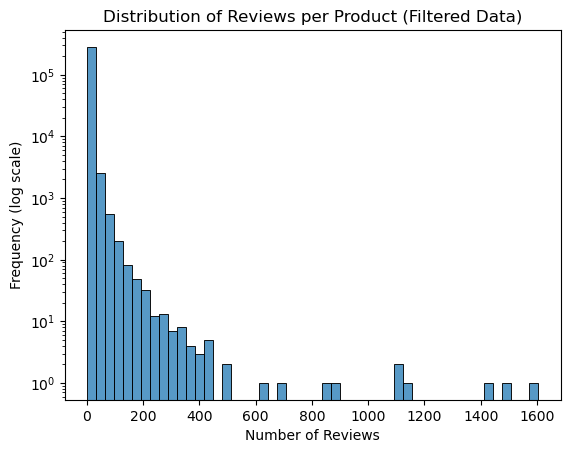

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(asin_review_counts, bins=50, kde=False)
plt.yscale('log')  # Apply log scale to the y-axis
plt.title(f"Distribution of Reviews per Product (Filtered Data)")
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency (log scale)')
plt.show()

#Power law distribution evident

In [62]:
#Change to something that makes sense for your PC
threads = 8
neutral_threshold = 0.1  # Bin around 0 that indicate a neutral sentiment

# Function to process a batch of reviews
def analyze_batch_sentiment(batch):
    sia = SentimentIntensityAnalyzer()
    return [sia.polarity_scores(str(text))['compound'] for text in batch]

# More is faster but uses more resources
batch_size = 10000

# Batch Generator
batches = [df_cleaned['text'][i:i + batch_size] for i in range(0, len(df_cleaned), batch_size)]

with tqdm_joblib(desc="Sentiment Analysis", total=len(batches)):
    sentiment_scores_batches = Parallel(n_jobs=threads)(
        delayed(analyze_batch_sentiment)(batch) for batch in batches
    )

# Flatten the list of batches into a single list
sentiment_scores = [score for batch_scores in sentiment_scores_batches for score in batch_scores]



# Add sentiment score and category to dataframe
df_cleaned['sentiment_score'] = sentiment_scores
df_cleaned['sentiment_category'] = df_cleaned['sentiment_score'].apply(
    lambda x: 'positive' if x > neutral_threshold else ('negative' if x < -neutral_threshold else 'neutral')
)

Sentiment Analysis:   0%|          | 0/17 [00:00<?, ?it/s]

In [63]:
# Save the cleaned dataset:
output_path = "Movies_and_TV_Cleaned_Sentiment.csv"
df_cleaned.to_csv(output_path, index=False)

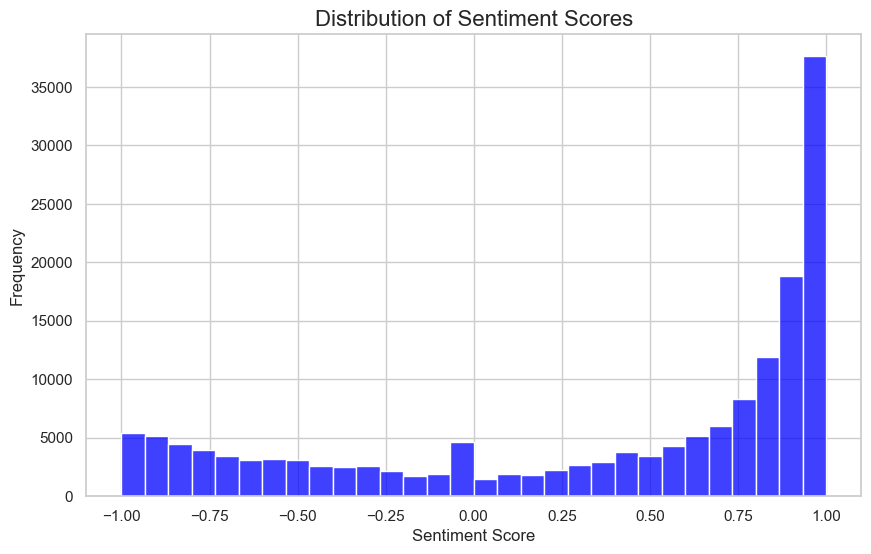

C:\Users\Friis\AppData\Local\Temp\ipykernel_12968\2320508608.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)


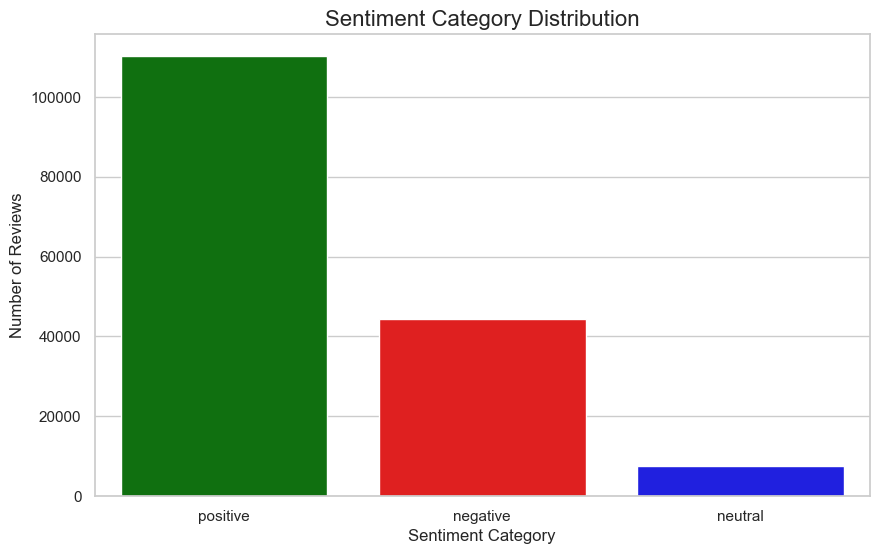

In [64]:
sns.set(style="whitegrid")

# Distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['sentiment_score'], kde=False, bins=30, color='Blue')
plt.title('Distribution of Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Sentiment Category Histogram
sentiment_counts = df_cleaned['sentiment_category'].value_counts()

colors = ['Green', 'Red', 'Blue']  # Positive, Negative, Neutral
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)
plt.title('Sentiment Category Distribution', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

In [ ]:
# Create a bipartite graph
G = nx.Graph()

# Add nodes for users and products
users = df_cleaned['user_id'].unique()
products = df_cleaned['asin'].unique()

# Add the user and product nodes to the graph
G.add_nodes_from(users, bipartite=0)  # Users will be in set 0
G.add_nodes_from(products, bipartite=1)  # Products will be in set 1

# Add edges between users and products (if a user reviewed a product)
edges = [(row['user_id'], row['asin']) for _, row in df_cleaned.iterrows()]
G.add_edges_from(edges)